In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Environment variables
NUM_DAYS = 1000  # Total number of days
NUM_ROUNDS_PER_DAY = 10  # Number of auction rounds per day
NUM_PRICES = 10  # Number of discrete prices
CHANGE_INTERVAL = 1  # Interval for changing the user buying probability distribution

# Pricing strategy variables
CONVERSION_RATE_MEAN = 0.5  # Mean of the initial conversion rate
CONVERSION_RATE_STD = 0.1  # Standard deviation of the initial conversion rate

# Auction variables
BID_WIN_PROBABILITY = 0.5  # Probability of winning an auction round


In [ ]:
class AdversarialPricingEnvironment:
    def __init__(self, num_arms, change_interval):
        self.num_arms = num_arms
        self.change_interval = change_interval
        self.t = 0
        self.buying_probabilities = self._generate_buying_probabilities()

    def _generate_buying_probabilities(self):
        # Generate initial probabilities
        return np.random.rand(self.num_arms)

    def reset(self):
        # Reset the probabilities (simulate a new day)
        self.buying_probabilities = self._generate_buying_probabilities()

    def round(self, a_t):
        prob = self.buying_probabilities[a_t]
        self.t += 1
        return np.random.rand() < prob



In [ ]:
class UCB1:
    def __init__(self, num_arms):
        self.num_arms = num_arms
        self.counts = np.zeros(num_arms)
        self.values = np.zeros(num_arms)
        self.total_counts = 0

    def select_arm(self):
        if self.total_counts < self.num_arms:
            return self.total_counts  # Play each arm once initially

        upper_bounds = self.values + np.sqrt((2 * np.log(self.total_counts)) / self.counts)
        return np.argmax(upper_bounds)

    def update(self, chosen_arm, reward):
        self.counts[chosen_arm] += 1
        self.total_counts += 1
        n = self.counts[chosen_arm]
        value = self.values[chosen_arm]
        # Incremental update to the estimated value
        new_value = ((n - 1) / n) * value + (1 / n) * reward
        self.values[chosen_arm] = new_value


In [ ]:
class HedgeAgent:
    def __init__(self, K, learning_rate):
        self.K = K
        self.learning_rate = learning_rate
        self.weights = np.ones(K)
        self.x_t = np.ones(K) / K
        self.a_t = None
        self.t = 0

    def pull_arm(self):
        self.x_t = self.weights / sum(self.weights)
        self.a_t = np.random.choice(np.arange(self.K), p=self.x_t)
        return self.a_t

    def update(self, l_t):
        self.weights *= np.exp(-self.learning_rate * l_t)
        self.t += 1


In [ ]:
class BiddingAgent:
    def __init__(self, bids_set, T, eta):
        self.bids_set = bids_set
        self.K = len(bids_set)
        self.hedge = HedgeAgent(self.K, eta)
        self.T = T
        self.t = 0

    def bid(self):
        return self.bids_set[self.hedge.pull_arm()]

    def update(self, f_t_full):
      # todo: implement this
      return


In [ ]:
class NonStationaryFirstPriceAuction:
    def __init__(self, available_bids, num_bidders, num_rounds):
        self.available_bids = available_bids
        self.num_bidders = num_bidders
        self.num_rounds = num_rounds
        self.round_counter = 0
        self.bids = self._generate_bids()

    def _generate_bids(self):
        return np.random.choice(self.available_bids, (self.num_rounds, self.num_bidders))

    def reset(self):
        self.bids = self._generate_bids()
        self.round_counter = 0

    def round(self, agent_bid):
        current_round_bids = self.bids[self.round_counter]
        max_bid = np.max(current_round_bids)
        win = agent_bid > max_bid
        self.round_counter += 1
        return max_bid, win


In [ ]:
# Initialize Hedge agent for bidding strategy
available_bids = np.linspace(0, 1, NUM_PRICES)  # Example bid space from 0 to 1
eta = np.sqrt(np.log(len(available_bids)) / (NUM_ROUNDS_PER_DAY * NUM_DAYS))  # Learning rate for Hedge
bidding_agent = BiddingAgent(bids_set=available_bids, T=NUM_ROUNDS_PER_DAY * NUM_DAYS, eta=eta)
num_bidders = 10
# Initialize Environment and Auction
env = AdversarialPricingEnvironment(num_arms=NUM_PRICES, change_interval=CHANGE_INTERVAL)
auction = NonStationaryFirstPriceAuction(available_bids=available_bids, num_bidders=num_bidders, num_rounds=NUM_ROUNDS_PER_DAY)
pricing_agent = UCB1(num_arms=NUM_PRICES)

# Simulation loop with auction and Hedge agent
total_rewards = 0
cumulative_regret = 0
cumulative_rewards = []
daily_regrets = []
daily_rewards = []
daily_probabilities = []

for day in range(NUM_DAYS):
    env.reset()
    auction.reset()

    daily_probabilities.append(env.buying_probabilities.copy())

    chosen_price = pricing_agent.select_arm()

    daily_reward = 0
    for round in range(NUM_ROUNDS_PER_DAY):
        agent_bid = bidding_agent.bid()

        max_bid, win = auction.round(agent_bid)

        if win:
            if env.round(chosen_price):
                daily_reward += 1

        reward = (env.buying_probabilities[chosen_price] - agent_bid) if win else -agent_bid
        f_t_full = np.array([(env.buying_probabilities[chosen_price] - b) if b < agent_bid else -b for b in available_bids])
        bidding_agent.update(f_t_full)

    pricing_agent.update(chosen_price, daily_reward)
    total_rewards += daily_reward

    optimal_reward = np.max(env.buying_probabilities) * NUM_ROUNDS_PER_DAY
    daily_regret = optimal_reward - daily_reward
    cumulative_regret += daily_regret

    daily_rewards.append(daily_reward)
    daily_regrets.append(daily_regret)
    cumulative_rewards.append(total_rewards)

    print(f"Day {day+1}, Daily Reward: {daily_reward}, Total Rewards: {total_rewards}, Daily Regret: {daily_regret}, Cumulative Regret: {cumulative_regret}")

cumulative_probabilities = np.mean(daily_probabilities, axis=0)
optimal_arm = np.argmax(cumulative_probabilities)

most_pulled_arm = np.argmax(pricing_agent.counts)

print(f"Simulation completed. Total rewards: {total_rewards}")
print(f"Cumulative regret: {cumulative_regret}")
print(f"Most pulled arm: {most_pulled_arm}")
print(f"Arm that should have been pulled the most: {optimal_arm}")


Day 1, Daily Reward: 1, Total Rewards: 1, Daily Regret: 7.998711919703172, Cumulative Regret: 7.998711919703172
Day 2, Daily Reward: 0, Total Rewards: 1, Daily Regret: 8.8761132663216, Cumulative Regret: 16.874825186024772
Day 3, Daily Reward: 0, Total Rewards: 1, Daily Regret: 8.025167142893325, Cumulative Regret: 24.899992328918096
Day 4, Daily Reward: 0, Total Rewards: 1, Daily Regret: 9.994857391996813, Cumulative Regret: 34.894849720914905
Day 5, Daily Reward: 0, Total Rewards: 1, Daily Regret: 9.114472840376793, Cumulative Regret: 44.0093225612917
Day 6, Daily Reward: 4, Total Rewards: 5, Daily Regret: 5.757085998979541, Cumulative Regret: 49.76640856027124
Day 7, Daily Reward: 0, Total Rewards: 5, Daily Regret: 9.113154792161959, Cumulative Regret: 58.879563352433195
Day 8, Daily Reward: 0, Total Rewards: 5, Daily Regret: 9.845082089211502, Cumulative Regret: 68.7246454416447
Day 9, Daily Reward: 0, Total Rewards: 5, Daily Regret: 9.473574897070224, Cumulative Regret: 78.1982203

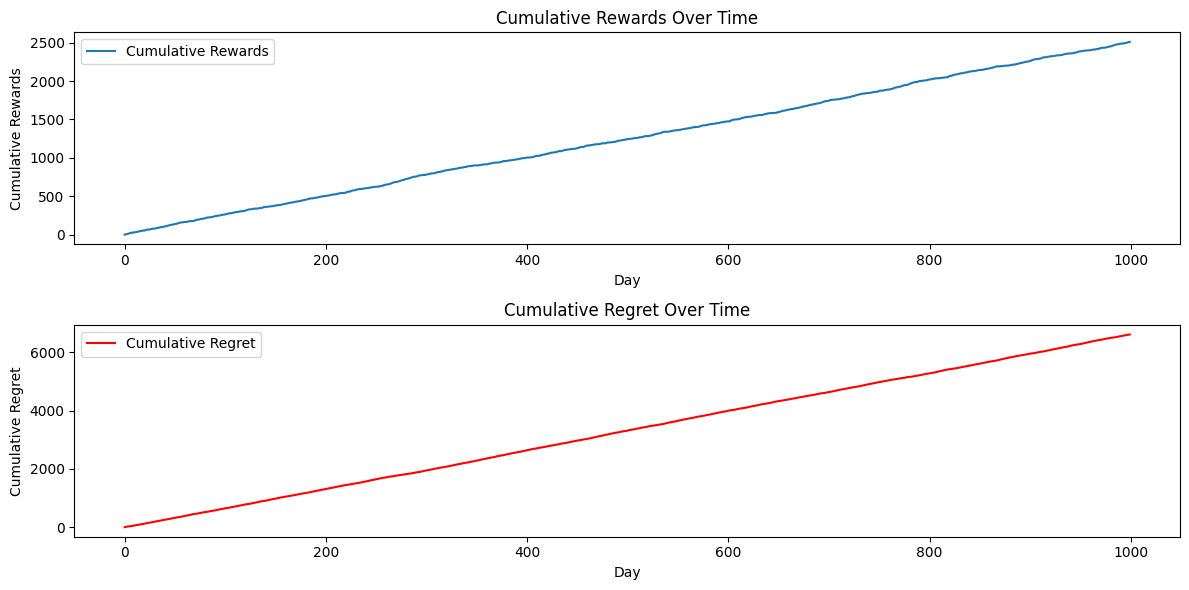

In [ ]:
# Plot the results
plt.figure(figsize=(12, 6))

# Plot cumulative rewards
plt.subplot(2, 1, 1)
plt.plot(range(NUM_DAYS), cumulative_rewards, label='Cumulative Rewards')
plt.xlabel('Day')
plt.ylabel('Cumulative Rewards')
plt.title('Cumulative Rewards Over Time')
plt.legend()

# Plot cumulative regret
plt.subplot(2, 1, 2)
plt.plot(range(NUM_DAYS), np.cumsum(daily_regrets), label='Cumulative Regret', color='red')
plt.xlabel('Day')
plt.ylabel('Cumulative Regret')
plt.title('Cumulative Regret Over Time')
plt.legend()

plt.tight_layout()
plt.show()